In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
from matplotlib import pyplot


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.cluster import KMeans

from scipy.optimize import minimize, LinearConstraint #for optimization





In [75]:
#read in the pre-processed training and test set from Dmitri's notebook
X_train = pd.read_csv("data/X_train_random_1592420882.csv")
Y_train = pd.read_csv("data/Y_train_random_1592420882.csv")
X_test = pd.read_csv("data/X_test_random_1592420882.csv")
Y_test = pd.read_csv("data/Y_test_random_1592420882.csv")

In [76]:
assert((X_train.shape[0] == Y_train.shape[0]) & (X_test.shape[0] == Y_test.shape[0]))

In [77]:
print(f'Dim of X_train: {X_train.shape}')
print(f'Dim of Y_train: {Y_train.shape}')
print("\n")
print(f'Dim of X_test: {X_test.shape}')
print(f'Dim of Y_test: {Y_test.shape}')

Dim of X_train: (1076080, 37)
Dim of Y_train: (1076080, 2)


Dim of X_test: (269020, 37)
Dim of Y_test: (269020, 2)


In [78]:
print(f'Train-test split: [{X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])},\
{X_test.shape[0]/(X_train.shape[0] + X_test.shape[0])}]')

Train-test split: [0.8,0.2]


In [79]:
dtypes_map={
'id':'uint32',
'application_type':'uint8',
'grade':'uint8',
'sub_grade':'uint8',
'term':'uint8',
'initial_list_status':'uint8',
'emp_length':'uint8',
'verification_status':'uint8',
'_has_desc':'uint8',
'purpose_credit_card':'uint8',
'purpose_debt_consolidation':'uint8',
'purpose_educational':'uint8',
'purpose_home_improvement':'uint8',
'purpose_house':'uint8',
'purpose_major_purchase':'uint8',
'purpose_medical':'uint8',
'purpose_moving':'uint8',
'purpose_other':'uint8',
'purpose_renewable_energy':'uint8',
'purpose_small_business':'uint8',
'purpose_vacation':'uint8',
'purpose_wedding':'uint8',
'home_ownership_OTHER':'uint8',
'home_ownership_OWN':'uint8',
'home_ownership_RENT':'uint8'
}

In [80]:
X_train = X_train.astype(dtype=dtypes_map)
X_test = X_test.astype(dtype=dtypes_map)


In [81]:
np.mean(Y_train.id == X_train.id)

1.0

In [82]:
np.mean(Y_test.id == X_test.id)

1.0

In [11]:
##we need to get fields needed for return calculations.
LC_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
LC_df.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [41]:
ret_df = LC_df[["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt", "recoveries","grade","sub_grade","loan_status"]].copy()

In [42]:
ret_df.term.value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [43]:
ret_df.dropna(subset=["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt"], inplace=True)

In [44]:
#convert term field to integer months
ret_df['term'] = ret_df['term'].apply(lambda t: np.int8(t.split()[0]))
ret_df.term.value_counts()


36    1607966
60     650275
Name: term, dtype: int64

In [45]:
#convert issue_d and last_pymnt_d into datetime
ret_df['issue_d'] = ret_df['issue_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())
ret_df['last_pymnt_d'] = ret_df['last_pymnt_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())

In [46]:
#calculate the realized term of the loan in months. 
ret_df['realized_loan_term_mths'] = round((ret_df['last_pymnt_d'] - ret_df['issue_d'])/np.timedelta64(1, 'M'))

In [47]:
#remove rows where realized_loan_term_mths = 0
ret_df = ret_df[ret_df.realized_loan_term_mths > 0]

In [48]:
ret_df.shape

(2249276, 11)

Function calc_return(....)

    calculate the effective(realized) annualized return on the funded amount of a loan
    assumption 1: monthly cash flow can be invested at a monthly rate of return rr
    This assumption allows us to simplify the return calculation to a sum of a geometric series
    with cash payments of: m, m(1+rr), m(1+rr)^2, m(1+rr)^3, ...,m(1+rr)^(last_pymnt_d -1) at the 
    end of months: 0,1,2,3,...last_pyment_d - 1 respectively
    The sequence of cash flows then forms a geometric series of the form
                                        a + ar + ar2 + ... + ar(n-1)
                                        which has a closed form sum:
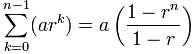

    where r = (1+rr) and a = m, the effective monthly installment payment over the actual life of the loan.
    
    assumption 2: when loan terminates early(due to default or pre-payment) total cash received
    + accrued interest are re-invested at the same rate rr from that time till the term of the loan

In [49]:
def calc_return(total_pymnt, term, funded_amnt, recoveries, realized_loan_term_mths, r=0.01):
    effective_monthly_installments = (total_pymnt - recoveries)/realized_loan_term_mths
    
    #get total cash flow at loan termination as the geometric sum of effective monthly installments
    #yielding a constant rate of return rr.
    #This is from assumption #1
    rr =r/12 #expecting r to be the annual yield
    total_cash_flow = effective_monthly_installments * ((1 - (1 + rr)**realized_loan_term_mths)) / (1 - (1 + rr))
    
    #add back recoveries to the get the lump sum at loan termination.
    total_cash_flow+= recoveries 

    #assumption #2. invest at rr till original term of loan.
    total_cash_flow = total_cash_flow * ((1 + rr)**(max(0,term - realized_loan_term_mths)))
    
    #calculate total return R and annualize
    R = (total_cash_flow - funded_amnt) / funded_amnt
    return ((1+R)**(12/term) - 1)


In [51]:
ret_df.sample(2)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,grade,sub_grade,loan_status,realized_loan_term_mths
668557,81545083,2016-06-01,2019-03-01,14627.750000,60,21000.0,0.0,B,B3,Current,33.0
1361733,145340437,2018-12-01,2019-03-01,30919.034641,60,30700.0,0.0,E,E2,Fully Paid,3.0


In [52]:
rr = 0.01
ret_df["annualized_returns"] = ret_df.apply(lambda row: calc_return(row[3], row[4], row[5], row[6], row[10], rr), axis =1)

In [53]:
ret_df.shape

(2249276, 12)

In [54]:
ret_df = ret_df.astype({'id': 'uint32'})


(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4]),
 <a list of 8 Text xticklabel objects>)

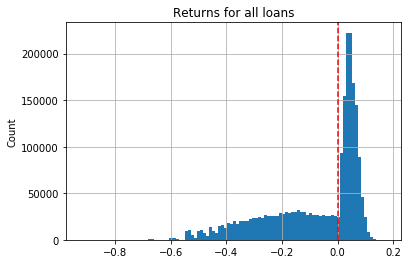

In [55]:
ret_df.hist('annualized_returns', bins=100)
pyplot.axvline(x=0, color='r', linestyle='--')
pyplot.title("Returns for all loans")
pyplot.ylabel("Count")
pyplot.xticks()

Text(0.5, 0, 'Annualized Returns')

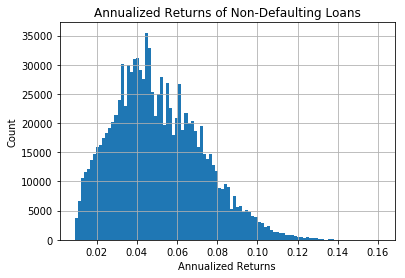

In [62]:
ret_df.loc[(ret_df.loan_status == 'Fully Paid')].hist('annualized_returns', bins=100)
pyplot.title("Annualized Returns of Non-Defaulting Loans")
pyplot.ylabel("Count")
pyplot.xlabel("Annualized Returns")

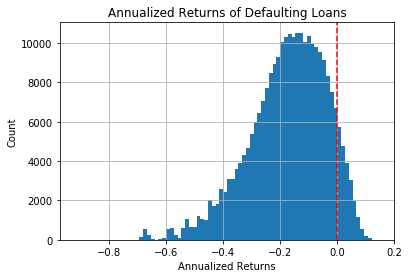

In [65]:
ret_df.loc[(ret_df.loan_status == 'Charged Off')].hist('annualized_returns', bins=80)
pyplot.title("Annualized Returns of Defaulting Loans")
pyplot.ylabel("Count")
pyplot.xlabel("Annualized Returns")
pyplot.axvline(x=0, color='r', linestyle='--')


In [68]:
ret_df.loc[(ret_df.loan_status == 'Charged Off') & (ret_df.annualized_returns >= 0)].shape[0]/ret_df.loc[(ret_df.loan_status == 'Charged Off')].shape[0]

0.08140299213840613

In [69]:
def fit_return_models(X_train, Y_train, X_test, Y_test, model_name ="Ridge",
                      cv_parameters = {},
                      random_state = 1980):
    '''
    fits 2 return models using the sklearn model object implied by model name. One model for loans that defaulted and another for 
    loans that didn't default.
    code borrowed mostly from the danguetta.com paper/notebook.
    '''
    
    np.random.seed(random_state)
    
    #choose model based on user selection
    if model_name == "Lasso":
        model = linear_model.Lasso(normalize=True)
    elif model_name == "Ridge":
        model = linear_model.Ridge(normalize=True)
    elif model_name == "RandomF":
        model = RandomForestRegressor()

    
 
    #split data into defaulted series and non-defaulted series

    Y_train_bad = Y_train.loc[(Y_train._good == 0),['id', 'annualized_returns'] ]
    X_train_bad = X_train[X_train.id.isin(Y_train_bad.id)]
    Y_test_bad  = Y_test.loc[(Y_test._good == 0),['id', 'annualized_returns'] ]
    X_test_bad  = X_test[X_test.id.isin(Y_test_bad.id)]
    
    Y_train_good = Y_train.loc[(Y_train._good == 1),['id', 'annualized_returns'] ]
    X_train_good = X_train[X_train.id.isin(Y_train_good.id)]  
    Y_test_good  = Y_test.loc[(Y_test._good == 1),['id', 'annualized_returns'] ]
    X_test_good  = X_test[X_test.id.isin(Y_test_good.id)]

    
    ##remove ids for now to be added back afterwards
    train_bad_loan_ids = X_train_bad.pop('id')
    test_bad_loan_ids = pd.DataFrame(X_test_bad.pop('id'), columns=['id'])


    train_good_loan_ids = X_train_good.pop('id')
    test_good_loan_ids = pd.DataFrame(X_test_good.pop('id'), columns=['id'])
    

    
    ##drop ids from Y datasets
    Y_train_good.drop('id', axis =1, inplace=True)
    Y_train_bad.drop('id', axis=1, inplace=True)
    
    Y_test_good.drop('id', axis =1, inplace=True)
    Y_test_bad.drop('id', axis =1, inplace=True)
    

    
    ##run model
    cv_model_bad = GridSearchCV(model, cv_parameters, scoring='r2')
    cv_model_good = GridSearchCV(model, cv_parameters, scoring='r2')

    #time and fit the models
    start_time = time.time()
    print("fitting model for defaulted loans")
    if model_name in ['RandomF']:
        cv_model_bad.fit(X_train_bad, Y_train_bad.values.ravel())
    else:
        cv_model_bad.fit(X_train_bad, Y_train_bad)
        
    print("fitting model for non-defaulted loans")
    if model_name in ['RandomF']:
        cv_model_good.fit(X_train_good, Y_train_good.values.ravel())
    else:
        cv_model_good.fit(X_train_good, Y_train_good)
        
    end_time = time.time()

    #pick best model from the fit for each regressor
    best_model_bad = cv_model_bad.best_estimator_
    best_model_good = cv_model_good.best_estimator_
            
    #tidy outputs    
    print("=========================")
    print("  Model: " + model_name )
    print("=========================")

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print("model_default:",cv_model_bad.best_params_, "model_non-default",cv_model_good.best_params_)

    ##predicted returns - need to join back to get loan ids
    predicted_non_default_return = pd.DataFrame(best_model_good.predict(X_test_good), columns =['ret'])
    predicted_default_return     = pd.DataFrame(best_model_bad.predict(X_test_bad), columns =['ret'])
    
    
    ## add ids back
    predicted_non_default_return = list(zip(test_good_loan_ids.id, predicted_non_default_return.ret))
    
    predicted_default_return = list(zip(test_bad_loan_ids.id, predicted_default_return.ret))
    
    print("")
    print("Testing r2 scores:")
    # Here we use different testing set to report the performance
    test_scores = {'model_default':r2_score(Y_test_bad,best_model_bad.predict(X_test_bad)),
                      'model_non_default':r2_score(Y_test_good,best_model_good.predict(X_test_good))}
 
    print("model_default:", test_scores['model_default'])
    print("model_non_default:", test_scores['model_non_default'])

    return { 'model_default':best_model_bad, 'model_non_default':best_model_good, 'predicted_non_default_return':predicted_non_default_return,
              'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

    
    


### Testing stuff


In [83]:
#pd.DataFrame(ret_df.issue_d.apply(lambda t:t.year)).groupby('issue_d').size().sort_values(ascending=False)

In [84]:
my_X_train = X_train.copy()
my_Y_train = Y_train.copy()

my_X_test = X_test.copy()
my_Y_test = Y_test.copy()

In [85]:
#merge returns data
my_Y_train = pd.merge(my_Y_train, ret_df[['id','annualized_returns']], how="left", on ='id')
my_Y_test = pd.merge(my_Y_test, ret_df[['id','annualized_returns']], how="left", on ='id')


In [86]:
my_Y_test.isnull().sum(axis=0)

id                       0
_good                    0
annualized_returns    2253
dtype: int64

In [87]:
my_Y_train.dropna(inplace=True)
my_Y_test.dropna(inplace=True)

## Test regression models


### Ridge

In [88]:
cv_parameters = {'alpha': np.logspace(-8, 2, num = 10), 'max_iter' : [2000]}

reg_ridge = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 25.02 seconds
Optimal parameters:
model_default: {'alpha': 2.1544346900318867e-05, 'max_iter': 2000} model_non-default {'alpha': 1.6681005372000591e-06, 'max_iter': 2000}

Testing r2 scores:
model_default: 0.09609842763909493
model_non_default: 0.3688380393363825


In [89]:
list_ids, returns_non_defaults = zip(*reg_ridge['predicted_non_default_return'])
list_ids, returns_defaults = zip(*reg_ridge['predicted_default_return'])

actual_defaults  = my_Y_test.loc[(my_Y_test._good == 0),['annualized_returns']]
actual_non_defaults = my_Y_test.loc[(my_Y_test._good == 1),['annualized_returns']]


In [90]:
print("Means of various populations, actual vs. pred:")
print("-"*50)
print(f'actual_non_defaults:{np.mean(actual_non_defaults.annualized_returns):.4f}')
print(f'predicted_non_defaults:{np.mean(returns_non_defaults):.4f}')
print("\n")
print(f'actual_defaults:{np.mean(actual_defaults.annualized_returns):.4f}')
print(f'predicted_defaults:{np.mean(returns_defaults):.4f}')

Means of various populations, actual vs. pred:
--------------------------------------------------
actual_non_defaults:0.0506
predicted_non_defaults:0.0506


actual_defaults:-0.1729
predicted_defaults:-0.1727


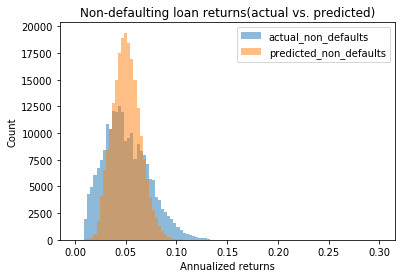

In [93]:
bins = np.linspace(-0., 0.3, 100)

pyplot.hist(actual_non_defaults.annualized_returns, bins, alpha=0.5, label='actual_non_defaults')

pyplot.hist(returns_non_defaults, bins, alpha=0.5, label='predicted_non_defaults')

pyplot.legend(loc='upper right')
pyplot.title("Non-defaulting loan returns(actual vs. predicted)")
pyplot.ylabel("Count")
pyplot.xlabel("Annualized returns")
pyplot.show()

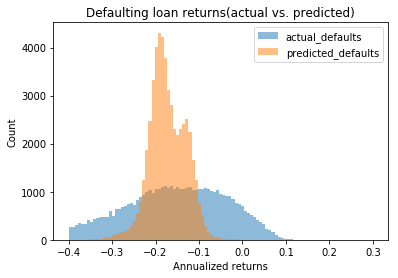

In [95]:
bins = np.linspace(-0.4, 0.3, 100)

pyplot.hist(actual_defaults.annualized_returns,  bins, alpha=0.5, label='actual_defaults')
pyplot.hist(returns_defaults,  bins, alpha=0.5, label='predicted_defaults')
pyplot.legend(loc='upper right')
pyplot.title("Defaulting loan returns(actual vs. predicted)")
pyplot.ylabel("Count")
pyplot.xlabel("Annualized returns")
pyplot.show()

### Random Forest

In [526]:
# #to be fine tuned...but too slow on my mac. took 2hours to run with these parameters!
# cv_parameters = {'min_samples_leaf':[100],
#                  'n_estimators': [100] }

# reg_rf = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="RandomF",
#                cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-526-bf4c6c655537>", line 6, in <module>
    cv_parameters = cv_parameters)
  File "<ipython-input-513-b3af62e766ad>", line 68, in fit_return_models
    cv_model_good.fit(X_train_good, Y_train_good.values.ravel())
  File "/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 736, in fit
    self._run_search(evaluate_candidates)
  File "/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 1188, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/skle

KeyboardInterrupt: 

In [96]:
my_Y_train.columns

Index(['id', '_good', 'annualized_returns'], dtype='object')

In [97]:
#### create risk data.
risk_data_train = pd.merge(my_X_train[['id', 'grade', 'sub_grade', 'term']], my_Y_train, how='inner', on='id')

In [98]:
risk_data_train.isnull().sum(axis=0)

id                    0
grade                 0
sub_grade             0
term                  0
_good                 0
annualized_returns    0
dtype: int64

In [99]:
##create risk scores

def var_95(ret):
    return np.percentile(ret,  5)

def var_99(ret):
    return np.percentile(ret, 1)

def ES_95(ret):
    threshold = var_95(ret)
    return np.mean(ret[ret < threshold])

def ES_99(ret):
    threshold = var_99(ret)
    return np.mean(ret[ret < threshold])



In [100]:
risk_summary_grades_all = pd.DataFrame(risk_data_train.groupby(['grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()



In [101]:
risk_summary_sub_grades_all = pd.DataFrame(risk_data_train.groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()


In [102]:
risk_summary_sub_grades_5yr = pd.DataFrame(risk_data_train.loc[(risk_data_train.term == 1)].groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()


In [103]:
risk_summary_sub_grades_3yr = pd.DataFrame(risk_data_train.loc[(risk_data_train.term == 0)].\
                                           groupby(['sub_grade'])['annualized_returns'].\
                                           agg(['count', 'median' , 'mean', 'min','max', 'std',\
                                           var_95, var_99, ES_95, ES_99])).reset_index()


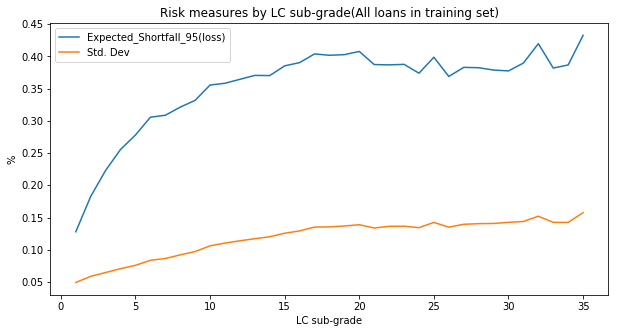

In [128]:
risk_summary_sub_grades_all
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_all.sub_grade, abs(risk_summary_sub_grades_all.ES_95))
pyplot.plot(risk_summary_sub_grades_all.sub_grade, risk_summary_sub_grades_all['std'])

pyplot.legend(['Expected_Shortfall_95(loss)', 'Std. Dev'], loc='upper left')
pyplot.title('Risk measures by LC sub-grade(All loans in training set)')
pyplot.xlabel('LC sub-grade')
pyplot.ylabel('%')
pyplot.show()

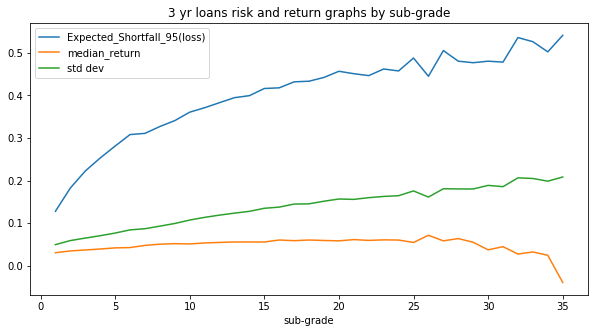

In [104]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, abs(risk_summary_sub_grades_3yr.ES_95))
pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, risk_summary_sub_grades_3yr['median'])
pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, risk_summary_sub_grades_3yr['std'])
#pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/abs(risk_summary_sub_grades_3yr.ES_95)))

pyplot.legend(['Expected_Shortfall_95(loss)', 'median_return', 'std dev'], loc='upper left')
pyplot.title('3 yr loans risk and return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

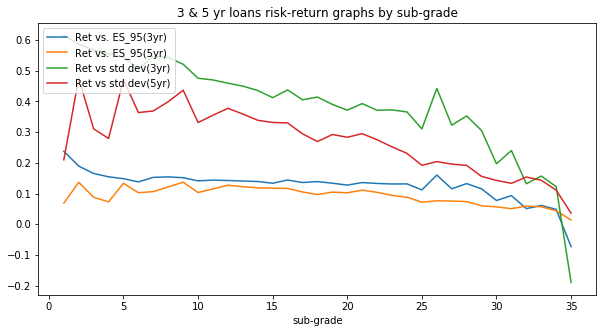

In [105]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/abs(risk_summary_sub_grades_3yr.ES_95)))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, (risk_summary_sub_grades_5yr['median']/abs(risk_summary_sub_grades_5yr.ES_95)))

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/risk_summary_sub_grades_3yr['std']))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, (risk_summary_sub_grades_5yr['median']/risk_summary_sub_grades_5yr['std']))

pyplot.legend(['Ret vs. ES_95(3yr)', 'Ret vs. ES_95(5yr)', 'Ret vs std dev(3yr)', 'Ret vs std dev(5yr)'], loc='upper left')
pyplot.title('3 & 5 yr loans risk-return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

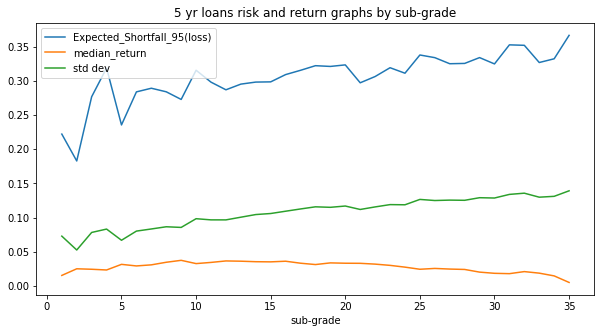

In [106]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, abs(risk_summary_sub_grades_5yr.ES_95))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, risk_summary_sub_grades_5yr['median'])
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, risk_summary_sub_grades_5yr['std'])

pyplot.legend(['Expected_Shortfall_95(loss)', 'median_return', 'std dev'], loc='upper left')
pyplot.title('5 yr loans risk and return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

In [107]:

##try some K-means clustering: do these clusters mean anything?
n_clusters = 5
my_X_train['cluster'] = 0

kmeans = KMeans(n_clusters=n_clusters, random_state=1980, verbose=0).fit(my_X_train.drop(['id','cluster'], axis=1))



In [108]:
my_X_train['cluster'] = kmeans.predict(my_X_train.drop(['id','cluster'], axis=1))


In [109]:
risk_data_train['cluster'] =0
risk_data_train = pd.merge(risk_data_train.drop('cluster', axis=1), my_X_train[['id','cluster']], how='left', on='id')

In [110]:
risk_data_train.columns

Index(['id', 'grade', 'sub_grade', 'term', '_good', 'annualized_returns',
       'cluster'],
      dtype='object')

In [111]:
risk_summary_clusters_all = pd.DataFrame(risk_data_train.groupby(['cluster'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()
risk_summary_clusters_all.sort_values('median')

,cluster,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
1,1,50,0.036385,-0.016211,-0.462233,0.078553,0.129427,-0.333319,-0.424300,-0.402577,-0.462233
3,3,52145,0.037987,0.011607,-0.693389,0.141969,0.098817,-0.228284,-0.405901,-0.337573,-0.492639
2,2,2409,0.038309,0.014952,-0.686887,0.131008,0.099629,-0.209834,-0.443489,-0.359313,-0.535073
0,0,347884,0.039347,0.008085,-0.921296,0.159925,0.102869,-0.237755,-0.404775,-0.338806,-0.484258
4,4,664558,0.043204,0.004383,-0.834690,0.160690,0.113807,-0.263372,-0.430535,-0.365357,-0.507192


In [112]:
risk_summary_grades_all.sort_values('median')

,grade,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
6,7,7206,0.018225,-0.045276,-0.663302,0.159153,0.147334,-0.318800,-0.442382,-0.401827,-0.524884
5,6,25422,0.028999,-0.024950,-0.797256,0.160690,0.139058,-0.290732,-0.429361,-0.377210,-0.506761
0,1,186727,0.034808,0.020314,-0.819906,0.079302,0.066032,-0.048840,-0.341043,-0.231734,-0.443174
4,5,74217,0.038948,-0.016533,-0.745056,0.141969,0.136494,-0.292777,-0.442430,-0.387008,-0.522714
1,2,311742,0.045962,0.016012,-0.908308,0.108635,0.093967,-0.214864,-0.396455,-0.327910,-0.480852
3,4,159043,0.048188,-0.007220,-0.921296,0.159925,0.134665,-0.304214,-0.464207,-0.400490,-0.536537
2,3,302689,0.048532,0.003030,-0.839784,0.144289,0.117306,-0.270609,-0.436392,-0.369379,-0.506276


In [113]:
useRidge = 1

#make predictions on the test sample using both models
if useRidge:
    pred_ret_if_non_defaulting = reg_ridge['model_non_default'].predict(my_X_test.drop('id', axis=1))[:,0]
    pred_ret_if_defaulting = reg_ridge['model_default'].predict(my_X_test.drop('id', axis=1))[:,0]
    regressor_used ="Ridge"
else:
    pred_ret_if_non_defaulting = reg_rf['model_non_default'].predict(my_X_test.drop('id', axis=1))
    pred_ret_if_defaulting = reg_rf['model_default'].predict(my_X_test.drop('id', axis=1))
    regressor_used ="Random Forest"

In [114]:
##combine the predicted returns from ridge regressor into a single dataframe to join with predicted default probs

pred_returns_good =pd.DataFrame({'id': my_X_test.id, 'pred_ret_good': pred_ret_if_non_defaulting })
pred_returns_bad =pd.DataFrame({'id': my_X_test.id.values, 'pred_ret_bad': pred_ret_if_defaulting})

combined_pred_returns = pd.merge(pred_returns_good, pred_returns_bad, how='inner', on='id')

In [115]:
###this is where i stopped

In [116]:
def_predictions = pd.read_csv("data/predictions_random_1592421122.csv")

In [117]:
### add [grade, sub_grade, term] to def_predictions
#get subset from prediction df
LC_subset_df = LC_df[LC_df.id.isin(def_predictions.id)]
LC_subset_df = LC_subset_df.astype({'id': 'int64'})


In [118]:
def_predictions = pd.merge(def_predictions, LC_subset_df[['id','grade','sub_grade','term','loan_amnt','funded_amnt']], how ='inner', on='id')

In [119]:
##convert grade, sub_grade and term to numbers - from Dmitri's notebook
sub_grades = sorted(def_predictions.sub_grade.unique())
sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades}  # map 'A1' to 1 rather than 0

ordinal_dict = {
    'grade':   {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7},
    'sub_grade': sub_grades_dict,
    'term': {' 36 months':0, ' 60 months':1}
}

for f in ['grade', 'sub_grade','term']:
    def_predictions[f].replace(ordinal_dict[f], inplace=True)


In [120]:
def_predictions = pd.merge(def_predictions, combined_pred_returns, how="left", on='id')

In [121]:
def_predictions.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad
103693,57894758,0,0.807790,2,9,0,20000.0,20000.0,0.050594,-0.169804
52175,8775314,0,0.772953,4,17,1,10000.0,10000.0,0.055680,-0.125806
99468,45584283,1,0.731344,3,12,0,5000.0,5000.0,0.058573,-0.165454
187818,98847349,1,0.826042,3,13,0,6000.0,6000.0,0.061545,-0.182084
53191,4654855,0,0.789672,3,13,1,12000.0,12000.0,0.048149,-0.131940
222537,77901729,1,0.883790,2,6,0,15000.0,15000.0,0.040841,-0.181428
201664,6406295,1,0.708661,4,19,1,10800.0,10800.0,0.059744,-0.143095
88024,76221166,1,0.480220,6,26,1,15350.0,15350.0,0.062943,-0.182321
200095,41378273,1,0.872936,2,6,1,25000.0,25000.0,0.031127,-0.142022
15097,1143732,1,0.960672,1,2,0,1900.0,1900.0,0.040652,-0.163725


In [122]:
def calc_expected_ret(good, p, pred_ret_good, pred_ret_bad):
    if good:
        return (p * pred_ret_good) + ((1-p) * pred_ret_bad)
    else:
        return (p * pred_ret_bad)  + ((1-p) * pred_ret_good)

In [123]:
#calc expected returns
def_predictions['pred_expected_ret'] = def_predictions.apply(lambda row: calc_expected_ret(row._good, \
                                                                        row.p, row.pred_ret_good, row.pred_ret_bad), axis=1)

Text(0.5, 0, 'Annualized returns')

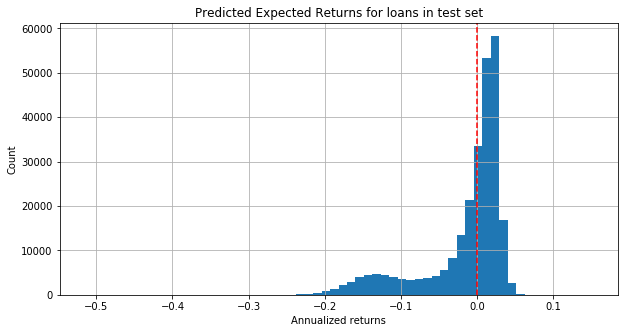

In [125]:
def_predictions.hist('pred_expected_ret', bins=60)
pyplot.axvline(x=0, color='r', linestyle='--')
pyplot.title("Predicted Expected Returns for loans in test set")
pyplot.ylabel("Count")
pyplot.xlabel("Annualized returns")


In [380]:
##choose std_dev and ES_95 as risk measures

def_predictions['risk_std_dev'] =0
def_predictions['risk_ES_95'] = 0


In [130]:
print(risk_summary_sub_grades_3yr.shape)
print(risk_summary_sub_grades_5yr.shape)

(35, 11)
(35, 11)


In [131]:
sub_grades = risk_summary_sub_grades_3yr.sub_grade.unique()


In [132]:
for sg in sub_grades:
    pred_std_dev_3yr = float(risk_summary_sub_grades_3yr[risk_summary_sub_grades_3yr.sub_grade == sg]['std'].values)
    pred_std_dev_5yr = float(risk_summary_sub_grades_5yr[risk_summary_sub_grades_5yr.sub_grade == sg]['std'].values)

    pred_ES_95_3yr = float(risk_summary_sub_grades_3yr[risk_summary_sub_grades_3yr.sub_grade == sg]['ES_95'].values)
    pred_ES_95_5yr = float(risk_summary_sub_grades_5yr[risk_summary_sub_grades_5yr.sub_grade == sg]['ES_95'].values)
    
    def_predictions.loc[(def_predictions['term'] == 0) & (def_predictions.sub_grade == sg) ,'risk_std_dev'] = pred_std_dev_3yr
    def_predictions.loc[(def_predictions['term'] == 1) & (def_predictions.sub_grade == sg),'risk_std_dev']  = pred_std_dev_5yr

    def_predictions.loc[(def_predictions['term'] == 0) & (def_predictions.sub_grade == sg),'risk_ES_95'] = pred_ES_95_3yr
    def_predictions.loc[(def_predictions['term'] == 1) & (def_predictions.sub_grade == sg),'risk_ES_95'] = pred_ES_95_5yr

    
    

In [133]:
def neg_risk_penalized_ret(notionals, pred_ret, risk, lambda_c):
    risk_adj_ret = pred_ret - (lambda_c * np.abs(risk))
    neg_ret = -1 * sum([x[0]*x[1] for x in zip(notionals, risk_adj_ret)])
    #print("Iterating:", neg_ret)
    return neg_ret



def portfolio_optimize(pred_ret,  funded_amts, budget = 1e6, lambda_c = 0.01, risk_measure = 1, risk_std=[], risk_ES=[]):
    '''
    risk can be either standard deviations or Expected Shortfall. Expected Shortfall is reported as negative
    so take the abs of the quantities there.
    risk_measure={0:standard deviation, 1:Expected shortfall}
    '''    
    if risk_measure:
        risk = risk_ES
    else:
        risk = risk_std
    
    assert(len(pred_ret) == len(risk) == len(funded_amts))

    init_notionals = [budget/len(pred_ret)] * len(pred_ret) #initialize variables
    arguments = (pred_ret, risk, lambda_c) #arguments into the objective function other than the variables
    
    linear_constraint = LinearConstraint(np.ones(len(init_notionals)), lb=0, ub=budget)  #total investment<=budget
    
    var_bounds = [(0, funded_amts[i]) for i in range(len(funded_amts))]
    
    opt_portfolio = minimize(neg_risk_penalized_ret, init_notionals,
                             args=arguments,
                             constraints=linear_constraint,
                             bounds=var_bounds,
                             method='SLSQP',
                             options={'ftol': 1e-5, 'disp': True, 'maxiter': 2000 }
                            )
    return opt_portfolio




## Test optimal portfolios


### seed with top n loans sorted by predicted expected returns


In [134]:
n =100
risk_aversion = 0.01

In [135]:
top_by_expected_ret = (def_predictions[['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]

In [136]:
def calc_realized_returns(optimal_portf):
    '''
    join with the returns dataframe to get the realized returns for each selected loan
    
    '''
    optimal_portf = pd.merge(optimal_portf, ret_df[['id','annualized_returns']], how='left', on='id')
    optimal_portf.annualized_returns.fillna(0, inplace=True)
    assert(len(optimal_portf.optimal_notionals) ==  len(optimal_portf.annualized_returns))
    num = np.sum([x[0]*x[1] for x in zip(optimal_portf.optimal_notionals, optimal_portf.annualized_returns)])
    den = np.sum(optimal_portf.optimal_notionals)
    return(num/den)

In [137]:
def get_optimized_portfolios(id_values, ret, funded_amnt, risk_aversion, risk_measure, risk):
    start_time = time.time()
    if risk_measure:
        opt_expected_ret_ES = portfolio_optimize(ret,
                                          funded_amnt, lambda_c = risk_aversion, \
                                          risk_measure = risk_measure, risk_ES=risk
                                         )
    else:
        opt_expected_ret_ES = portfolio_optimize(ret,
                                          funded_amnt, lambda_c = risk_aversion, \
                                          risk_measure = risk_measure, risk_std=risk
                                         )
    end_time = time.time()
    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Risk aversion parameter:", risk_aversion)
    
    opt_df = pd.DataFrame({'id':id_values, 'funded_amnt': funded_amnt, \
                  'optimal_notionals':opt_expected_ret_ES.x})
    opt_df.optimal_notionals = opt_df.optimal_notionals.apply(lambda val: round(val))
    return opt_df

In [138]:
lambda_c =[0.01, 0.005, 0.001, 0.0005]

In [139]:
#find the optimal risk_aversion parameter:
portf_ret_arr = [calc_realized_returns(get_optimized_portfolios(top_by_expected_ret.id.values, 
                                                                top_by_expected_ret.pred_expected_ret.values,
                                                                top_by_expected_ret.funded_amnt.values,
                                                                risk_aversion_parameter, 0,
                                                                top_by_expected_ret.risk_std_dev))\
 for risk_aversion_parameter in lambda_c]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69314.53977994826
            Iterations: 109
            Function evaluations: 11129
            Gradient evaluations: 109
Fit time: 3.31 seconds
Risk aversion parameter: 0.01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -70900.221756408
            Iterations: 279
            Function evaluations: 28367
            Gradient evaluations: 278
Fit time: 8.57 seconds
Risk aversion parameter: 0.005
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -71022.5615304557
            Iterations: 167
            Function evaluations: 17045
            Gradient evaluations: 167
Fit time: 5.44 seconds
Risk aversion parameter: 0.001
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -72279.78840198659
            Iterations: 867
            Function evaluations: 88056
            Grad

In [140]:
print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: Std dev")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr}).sort_values('max_returns', ascending=False)

N= 100
Regression algo: Ridge
risk measure: Std dev


,lambda,max_returns
0,0.0100,0.077352
2,0.0010,0.076821
1,0.0050,0.076610
3,0.0005,0.075931


In [325]:
print("N=",n)
print("Regression algo:", regressor_used)
print("risk measure: Std dev")
pd.DataFrame({'lambda': lambda_c, 'max_returns':portf_ret_arr}).sort_values('max_returns', ascending=False)

N= 100
Regression algo: Random Forest
risk measure: Std dev


,lambda,max_returns
4,0.000100,0.084724
6,0.000010,0.084457
3,0.000500,0.084438
8,0.000000,0.083792
2,0.001000,0.083752
1,0.005000,0.083619
7,0.000001,0.083607
5,0.000050,0.083562
0,0.010000,0.083439


### seed with top n loans sorted by predicted expected returns


In [141]:
n= 100
risk_aversion =0.01
print(regressor_used)

Ridge


In [142]:
top_by_expected_ret = (def_predictions[['id','pred_expected_ret','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_expected_ret', ascending=False)).iloc[:n,]

#### risk measure = expected shortfall


In [143]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_expected_ret.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_1 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_1.optimal_notionals = opt_df_1.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -68594.81057502849
            Iterations: 754
            Function evaluations: 76520
            Gradient evaluations: 750
Fit time: 7.79 seconds


#### risk measure = standard deviation


In [144]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_expected_ret.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_2 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_2.optimal_notionals = opt_df_2.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -69314.53977994826
            Iterations: 109
            Function evaluations: 11129
            Gradient evaluations: 109
Fit time: 3.65 seconds


### seed with top n loans sorted by predicted non_default returns


In [145]:
top_by_expected_ret = (def_predictions[['id','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('pred_ret_good', ascending=False)).iloc[:n,]

#### risk measure = expected shortfall


In [146]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_3 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_3.optimal_notionals = opt_df_3.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -102480.48588748077
            Iterations: 534
            Function evaluations: 54071
            Gradient evaluations: 530
Fit time: 5.22 seconds


#### risk measure = standard deviation


In [147]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_4 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_4.optimal_notionals = opt_df_4.optimal_notionals.apply(lambda val: round(val))


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -105088.38618067962
            Iterations: 531
            Function evaluations: 53784
            Gradient evaluations: 527
Fit time: 17.03 seconds


### seed with top n loans sorted by returns with highest probability of non-default


In [148]:
top_by_expected_ret = (def_predictions.loc[(def_predictions._good == 1),['id', '_good', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                        sort_values('p', ascending=False)).iloc[:n,]

#### risk measure = expected shortfall


In [149]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_5 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_5.optimal_notionals = opt_df_5.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -21351.563129978636
            Iterations: 278
            Function evaluations: 28356
            Gradient evaluations: 278
Fit time: 3.1 seconds


#### risk measure = standard deviation


In [150]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_6 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_6.optimal_notionals = opt_df_6.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -22222.14334048754
            Iterations: 246
            Function evaluations: 25092
            Gradient evaluations: 246
Fit time: 8.73 seconds


### seed with top n loans selected randomly


In [151]:
top_by_expected_ret = def_predictions[['id', '_good','grade', 'p','pred_ret_good','funded_amnt','risk_std_dev','risk_ES_95']].\
                       iloc[(np.random.randint(0,def_predictions.shape[0],n)),:]
                       

#### risk measure = expected shortfall


In [152]:
start_time = time.time()
opt_expected_ret_ES = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion, \
                                      risk_measure = 1,risk_ES=top_by_expected_ret.risk_ES_95.values
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_7 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_ES.x})
opt_df_7.optimal_notionals = opt_df_7.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -58304.16314396395
            Iterations: 1272
            Function evaluations: 129397
            Gradient evaluations: 1268
Fit time: 13.21 seconds


#### risk measure = standard deviation


In [153]:
start_time = time.time()

opt_expected_ret_std_dev = portfolio_optimize(top_by_expected_ret.pred_ret_good.values,
                                      top_by_expected_ret.funded_amnt.values, lambda_c = risk_aversion,\
                                      risk_measure = 0, risk_std=top_by_expected_ret.risk_std_dev
                                     )
end_time = time.time()
print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")

opt_df_8 = pd.DataFrame({'id':top_by_expected_ret.id.values, 'funded_amnt': top_by_expected_ret.funded_amnt, \
              'optimal_notionals':opt_expected_ret_std_dev.x})
opt_df_8.optimal_notionals = opt_df_8.optimal_notionals.apply(lambda val: round(val))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -60599.63155808435
            Iterations: 1277
            Function evaluations: 129857
            Gradient evaluations: 1273
Fit time: 42.07 seconds


### calculate realized returns of the 6 portfolios


In [154]:
##generate simple annualized returns -- don't kill me Simon!
opt_portf_arr = [opt_df_1, opt_df_2, opt_df_3, opt_df_4, opt_df_5, opt_df_6, opt_df_7, opt_df_8]
simple_ret_arr = [calc_realized_returns(portf) for portf in opt_portf_arr]

In [160]:

strategy =['Expected Returns,ES', 'Expected Returns,StdDev',\
           'R_non_default,any loan,ES', 'R_non_default,any loan,StdDev',\
           'R_non_default,non-defaulting loans only,ES', \
           'R_non_default,non-defaulting loans only,StdDev', 'Random,ES', 'Random,StdDev']
resultset = pd.DataFrame({'Filter': strategy, 'Realized_returns':simple_ret_arr}).\
                sort_values('Realized_returns', ascending=False)

In [428]:
print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
resultset

Risk aversion parameter: 0.01 
Regressor: Random Forest


,Selection_criteria,Actual_realized_returns
0,expected_ret_ES,0.083555
1,expected_ret_STDDEV,0.083439
4,non_default_prob_ret_ES,0.027802
5,non_default_prob_ret_STDDEV,0.027802
6,random_ES,-0.004566
7,random_STDDEV,-0.004699
2,non_default_scenario_ret_ES,-0.012114
3,non_default_scenario_ret_STDDEV,-0.012114


In [164]:
resultset.loc[(resultset.Filter == 'Random,ES')].Realized_returns.values

0.023853362307346204

In [165]:
resultset['Return_multiple'] = resultset.Realized_returns/resultset.loc[(resultset.Filter == 'Random,ES')].Realized_returns.values

In [167]:
resultset['Return_multiple'] = resultset.Return_multiple.apply(lambda val: "{:.2f}".format(val))

In [169]:
print("Risk aversion parameter:", risk_aversion, "\nRegressor:", regressor_used)
resultset[['Filter', 'Return_multiple']]

Risk aversion parameter: 0.01 
Regressor: Ridge


,Filter,Return_multiple
1,"Expected Returns,StdDev",3.24
0,"Expected Returns,ES",3.18
4,"R_non_default,non-defaulting loans only,ES",1.17
5,"R_non_default,non-defaulting loans only,StdDev",1.17
7,"Random,StdDev",1.00
6,"Random,ES",1.00
2,"R_non_default,any loan,ES",0.82
3,"R_non_default,any loan,StdDev",0.69


In [157]:
resultset.to_csv("optimizer_output.csv", index=False)

In [429]:
#best_portf_RF = opt_df_1

In [192]:
best_portf_Ridge = opt_df_1

In [193]:
best_portf_Ridge['weights'] = best_portf_Ridge.optimal_notionals/best_portf_Ridge.optimal_notionals.sum()

In [194]:
#best_portf_RF['weights'] = best_portf_RF.optimal_notionals/best_portf_RF.optimal_notionals.sum()

In [195]:
##send cut to Simon
#best_portf_Ridge[['id', 'weights']].to_csv('optimal_weights_ridge.csv',index=False)
#best_portf_RF[['id', 'weights']].to_csv('optimal_weights_randomF.csv',index=False)


In [196]:
best_portf_Ridge = pd.merge(best_portf_Ridge, ret_df[['id','term','grade','sub_grade','realized_loan_term_mths']], how='left', on='id')

In [197]:
best_portf_Ridge.sample(10)

,id,funded_amnt,optimal_notionals,weights,term,grade,sub_grade,realized_loan_term_mths
52,431602,18000.0,11014,0.011014,36,E,E4,36.0
43,837281,30000.0,20009,0.020009,60,G,G1,19.0
30,640263,19750.0,19750,0.019750,60,G,G4,44.0
99,405963,5500.0,23,0.000023,36,D,D3,5.0
56,677937,30000.0,7692,0.007692,36,F,F2,23.0
54,882281,32000.0,13368,0.013368,60,G,G3,60.0
46,876865,25025.0,20213,0.020213,60,F,F3,3.0
35,578793,3000.0,2732,0.002732,36,E,E3,36.0
14,374485,14000.0,13940,0.013940,36,F,F1,38.0
28,706606,24000.0,24000,0.024000,60,G,G3,44.0


In [198]:
weighted_avg_life = np.sum([x[0]*x[1] for x in zip(best_portf_Ridge.weights, best_portf_Ridge.realized_loan_term_mths)])
weighted_avg_life

33.49132349132349

In [199]:
weighted_avg_notional_invested = \
        np.sum([x[0]*x[1] for x in zip(best_portf_Ridge.weights, best_portf_Ridge.optimal_notionals)])
round(weighted_avg_notional_invested)

18033.0

In [200]:
best_portf_Ridge.loc[(best_portf_Ridge.weights>0)].shape[0]

92

In [204]:
group_by_grade = best_portf_Ridge.groupby(['grade'])['weights'].sum().reset_index().sort_values('weights', ascending=False)
group_by_grade

,grade,weights
5,G,0.439469
4,F,0.300010
3,E,0.223773
2,D,0.031917
0,B,0.003500
1,C,0.001330


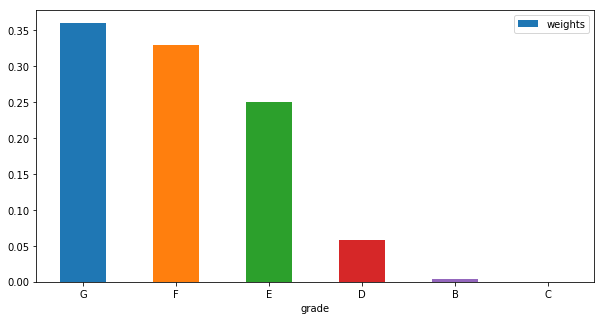

In [191]:
ax = group_by_grade.plot.bar(x='grade', y='weights', rot=0)

In [211]:
(best_portf_Ridge[['optimal_notionals', 'realized_loan_term_mths']].describe().T).to_csv("optimal_portf_stats.csv")

In [216]:
tmp = pd.read_csv("optimal_portf_stats.csv")

In [217]:
tmp


,statistic,count,mean,min,25%,50%,75%,max
0,amount_to_invest,100,10000,0,2136,7759,16189,35000
1,realized_loan_life,100,34,1,23,35,43,63
